In [0]:
# ============================================================
# 🚄 USE CASE 1: Passenger Sentiment Classification (IRCTC)
# ============================================================
# Goal:
# To analyze IRCTC customer reviews and classify each review 
# as Positive, Neutral, or Negative using Apache Spark MLlib.
#
# Why it matters:
# Understanding customer sentiment helps IRCTC improve their 
# services, identify pain points, and make data-driven decisions.
# ============================================================

# ------------------------------------------------------------
# 🧩 Step 1: Import Libraries and Start Spark Session
# ------------------------------------------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, regexp_replace, when
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Start Spark
spark = SparkSession.builder.appName("IRCTC_Sentiment_Classification").getOrCreate()
print("✅ Spark session started successfully!")

✅ Spark session started successfully!


In [0]:
# ------------------------------------------------------------
# 📂 Step 2: Load Dataset
# ------------------------------------------------------------
file_path = "/Volumes/workspace/default/dataset2/irctc_reviews.csv"

# Read CSV file
df = spark.read.option("header", "true").csv(file_path)
print("✅ Dataset loaded successfully!")
print(f"Total Rows: {df.count()}")
df.show(5, truncate=False)

✅ Dataset loaded successfully!
Total Rows: 1000
+------------------------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|reviewId                            |userName     |content                                                                                                                                                                                                                                                                                                                                                                |score|
+------------------------------------+-------------+--------------------------------------------------------------

In [0]:
# ------------------------------------------------------------
# 🧼 Step 3: Data Cleaning and Preparation
# ------------------------------------------------------------
# Clean text and safely cast score column
df = df.select(
    trim(col("content")).alias("review"),
    trim(col("score")).alias("score")
)

# Convert score to integer safely
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def safe_to_int(x):
    try:
        return int(x)
    except:
        return None

safe_to_int_udf = udf(safe_to_int, IntegerType())
df = df.withColumn("score_int", safe_to_int_udf(col("score")))

# Remove rows with missing data
df = df.filter(col("review").isNotNull() & col("score_int").isNotNull())
print("✅ Data cleaned and ready for processing.")
print(f"Remaining Rows: {df.count()}")

✅ Data cleaned and ready for processing.
Remaining Rows: 999


In [0]:
# ------------------------------------------------------------
# 🎯 Step 4: Create Sentiment Labels
# ------------------------------------------------------------
# Label mapping: 0 = Negative, 1 = Neutral, 2 = Positive
df = df.withColumn(
    "label",
    when(col("score_int") >= 4, 2)
    .when(col("score_int") == 3, 1)
    .otherwise(0)
)

# Clean text (remove symbols, lowercase)
df = df.withColumn("review", lower(regexp_replace(col("review"), "[^a-zA-Z\\s]", "")))

print("✅ Sentiment labels created successfully.")
df.select("review", "score_int", "label").show(5, truncate=False)

✅ Sentiment labels created successfully.
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----+
|review                                                                                                                                                                                                                                                                                                                                                              |score_int|label|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
# ------------------------------------------------------------
# 🧠 Step 5: Define a Reusable NLP + ML Pipeline
# ------------------------------------------------------------
# This pipeline will be reused for every use case
tokenizer = Tokenizer(inputCol="review", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=5000)
idf = IDF(inputCol="rawFeatures", outputCol="features")


In [0]:
# ------------------------------------------------------------
# 🤖 Step 6: Model Initialization
# ------------------------------------------------------------
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
nb = NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial")


In [0]:
# ------------------------------------------------------------
# 🧩 Step 7: Combine Preprocessing and Model in a Pipeline
# ------------------------------------------------------------
# This modular structure can be reused across all 5 use cases
def build_pipeline(model):
    return Pipeline(stages=[tokenizer, remover, hashingTF, idf, model])

In [0]:
# ------------------------------------------------------------
# 🔀 Step 8: Split Data for Training and Testing
# ------------------------------------------------------------
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print(f"Train Rows: {train_df.count()} | Test Rows: {test_df.count()}")

Train Rows: 838 | Test Rows: 161


In [0]:
# ------------------------------------------------------------
# 🚀 Step 9: Train and Evaluate All Models
# ------------------------------------------------------------
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "Naive Bayes": nb
}

results = []

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    pipeline = build_pipeline(model)
    pipeline_model = pipeline.fit(train_df)
    predictions = pipeline_model.transform(test_df)
    
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy"
    )
    accuracy = evaluator.evaluate(predictions)
    results.append((name, accuracy))
    print(f"✅ {name} Accuracy: {accuracy * 100:.2f}%")


🔹 Training Logistic Regression...
✅ Logistic Regression Accuracy: 72.67%

🔹 Training Random Forest...
✅ Random Forest Accuracy: 75.16%

🔹 Training Naive Bayes...
✅ Naive Bayes Accuracy: 85.09%


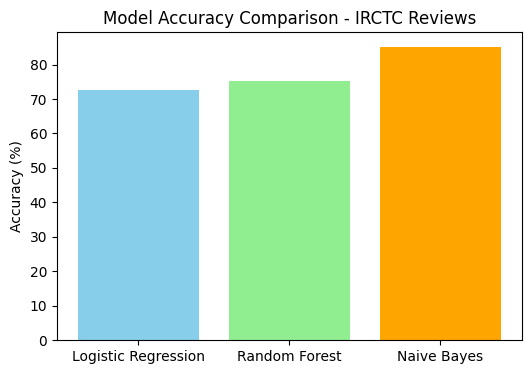


🏆 Best Performing Model: Naive Bayes


In [0]:
# ------------------------------------------------------------
# 📊 Step 10: Visualize Model Accuracy Comparison
# ------------------------------------------------------------
result_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
plt.figure(figsize=(6,4))
plt.bar(result_df["Model"], result_df["Accuracy"] * 100, color=["skyblue", "lightgreen", "orange"])
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison - IRCTC Reviews")
plt.show()

best_model_name = result_df.loc[result_df["Accuracy"].idxmax(), "Model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")

In [0]:
# ------------------------------------------------------------
# 🧾 Step 11: Predict Sample Reviews
# ------------------------------------------------------------
# Choose best model
best_pipeline = build_pipeline(models[best_model_name])
final_model = best_pipeline.fit(df)

# Create test examples
sample_data = [
    ("The app is great and booking is very easy",),
    ("Refund process is very slow and frustrating",),
    ("Food quality is good but service can improve",),
    ("The app keeps crashing every time I login",)
]
sample_df = spark.createDataFrame(sample_data, ["review"])

sample_predictions = final_model.transform(sample_df)
sample_predictions.select("review", "prediction").show(truncate=False)

+--------------------------------------------+----------+
|review                                      |prediction|
+--------------------------------------------+----------+
|The app is great and booking is very easy   |2.0       |
|Refund process is very slow and frustrating |0.0       |
|Food quality is good but service can improve|2.0       |
|The app keeps crashing every time I login   |0.0       |
+--------------------------------------------+----------+



In [0]:
# ------------------------------------------------------------
# 📈 Step 12: Sentiment Distribution Summary
# ------------------------------------------------------------
from pyspark.sql.functions import count

sentiment_summary = (
    df.groupBy("label")
    .agg(count("*").alias("count"))
    .orderBy("label")
)
sentiment_summary.show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  788|
|    1|   45|
|    2|  166|
+-----+-----+



In [0]:
# ------------------------------------------------------------
# 💾 Step 13: Save Outputs in Databricks (for Download)
# ------------------------------------------------------------
import pandas as pd
import os

# Create a Pandas DataFrame from Spark DataFrame
output_df = df.select("review", "label").toPandas()

# Define workspace save location
workspace_dir = "/Workspace/exports"
workspace_file = os.path.join(workspace_dir, "IRCTC_Sentiment_Results_UseCase1.csv")

# Ensure directory exists
os.makedirs(workspace_dir, exist_ok=True)

# Save CSV file
output_df.to_csv(workspace_file, index=False)

print(f"✅ File saved successfully inside Databricks Workspace:")
print(f"📁 Path: {workspace_file}")
print("➡ You can now go to 'Workspace > exports > IRCTC_Sentiment_Results_UseCase1.csv' and click 'Download'.")


✅ File saved successfully inside Databricks Workspace:
📁 Path: /Workspace/exports/IRCTC_Sentiment_Results_UseCase1.csv
➡ You can now go to 'Workspace > exports > IRCTC_Sentiment_Results_UseCase1.csv' and click 'Download'.


In [0]:
# ------------------------------------------------------------
# 🎯 Final Summary
# ------------------------------------------------------------
print(f"\n🧾 SUMMARY:")
print(f"Best Model: {best_model_name}")
print(f"Model Accuracy: {result_df[result_df['Model']==best_model_name]['Accuracy'].values[0]*100:.2f}%")
print("Sentiment classification completed successfully!")


🧾 SUMMARY:
Best Model: Naive Bayes
Model Accuracy: 85.09%
Sentiment classification completed successfully!
